In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
import pickle
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import networkx as nx
import mpld3
from tqdm import tqdm as tqdm
from collections import Counter

In [3]:
path = "/Users/mj/Desktop/INFORMS_CODE_FILE/network design code/Files_to_solve" ## Please set up a directory for the code file.

In [2]:
# Muggeo, V. M. (2003). Estimating regression models with unknown breakpoints. Statistics in medicine, 22(19), 3055-3071.

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 100

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return (Xsolution, Ysolution), a, b, Rk

maximum iteration reached
(array([  301.        ,  4509.69743171, 35682.        ]), array([3.49517419, 2.07648648, 1.289268  ]))


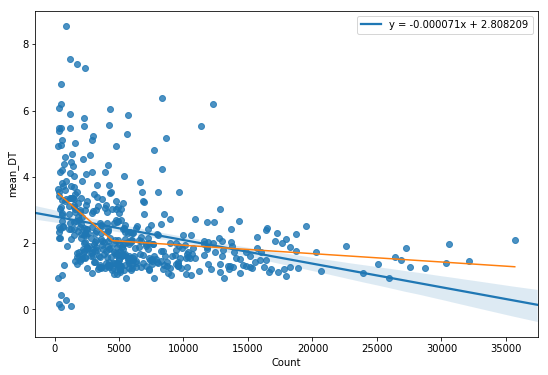

In [4]:
# Regression analysis on dwell times

df_vdc = pd.read_csv(path + '/CORRECTED_Results Template 1_VDC_DataSet1_Corrected.csv')
VDC = df_vdc.VDC.unique()

A = [(i,j) for i in VDC for j in VDC if i != j]

car_num_threshold = 300

DwellTime_year = {
    **pickle.load(open(path + "/DwellTime_year_dataset1.dump", "rb")),
    **pickle.load(open(path + "/DwellTime_year_dataset2.dump", "rb"))
}

mode = 'R'
DT_R = [
    (DwellTime_ij[a][mode].count(), DwellTime_ij[a][mode].mean(), mode) 
    for a in A
    for DwellTime_ij in DwellTime_year.values()
    if DwellTime_ij[a][mode].count() > car_num_threshold
]

mode = 'T'
DT_T = [
    (DwellTime_ij[a][mode].count(), DwellTime_ij[a][mode].mean(), mode) 
    for a in A
    for DwellTime_ij in DwellTime_year.values()
    if DwellTime_ij[a][mode].count() > car_num_threshold
]

df_DwellTime = pd.concat([
    pd.DataFrame(DT_R, columns=['Count', 'mean_DT', 'mode']),
    pd.DataFrame(DT_T, columns=['Count', 'mean_DT', 'mode'])
])


slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_DwellTime.Count, df_DwellTime.mean_DT
)

ax = sns.regplot(
    x='Count', 
    y='mean_DT', 
    data=df_DwellTime,
#     hue='mode',
    line_kws={'label': f'y = {slope:.6f}x + {intercept:.6f}'}
)

ax.figure.set_figwidth(9)
ax.figure.set_figheight(6)

seg_reg, a, b, Rk = SegmentedLinearReg(df_DwellTime.Count, df_DwellTime.mean_DT, [5000])
ax.plot(*seg_reg)
ax.legend()

print(seg_reg)

# mpld3.display(ax.figure)

